In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')

# Exploratory Data Analysis

In [3]:
df = pd.read_csv('../data/Train.csv', low_memory=False)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

None

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It looks like many columns are missing values, and some columns have mixed types. Recall that we aim to predict the sale price of a particular piece of heavy equipment based on its usage, equipment type, and configuration, so we first look at what features would be unknown prior to the auction and beyond the scope of this analysis.

Prior to the auction we would not have `SalesID`, `SalePrice` (our target variable, duh), or `saledate`. Although saledate would not be known prior to the auction, we would be able to know the age of the machine by comparing `saledate` and `YearMade`, so we should consider engineering that feature before dropping `saledate`.

Since we want to predict specifically based on usage, equipment type, and configuration, we can drop variables `datasource` and `auctioneerID`. 

The above features will be dropped prior to training the model. 

## Univariate Analyses 
### `SalePrice`
`SalePrice` is the dependent variable.

In [4]:
df['SalePrice'].describe()

count    401125.000000
mean      31099.712848
std       23036.898502
min        4750.000000
25%       14500.000000
50%       24000.000000
75%       40000.000000
max      142000.000000
Name: SalePrice, dtype: float64

/home/benedict/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


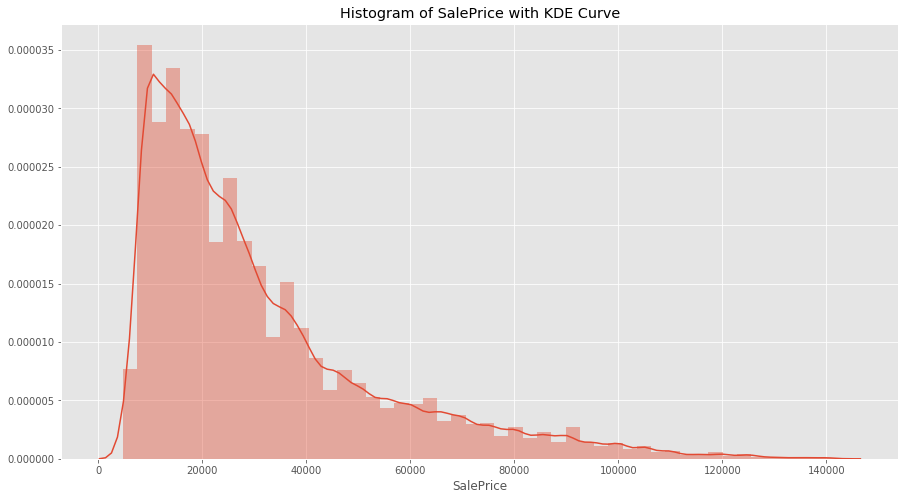

In [5]:
plt.figure(figsize=(15,8));
plt.title("Histogram of SalePrice with KDE Curve");
sns.distplot(df['SalePrice']);

### `MachineID`

Intuitively, `MachineID` shouldn't have a linear relationship with `SalePrice`, since it is a categorical feature indicating an ID number.

In [6]:
df['MachineID'].value_counts()

2283592    26
2285830    25
1942724    23
1896854    22
2296335    20
2277295    19
1746392    19
2014324    19
2296315    18
2273478    18
1789509    18
2268800    18
2208545    17
2300476    17
2271034    17
2293080    17
2282547    16
2302498    15
2306241    15
2296901    15
2302060    14
2288977    14
2304461    13
2283930    13
2300370    13
1537322    13
2292856    13
569515     12
843769     12
2277101    12
           ..
1928127     1
1024848     1
1026897     1
1698867     1
1540948     1
1018709     1
1045338     1
1047387     1
1844983     1
1450848     1
1543996     1
1360700     1
1444014     1
1370937     1
1409812     1
1434392     1
1436441     1
1438490     1
1440539     1
1430302     1
1313573     1
1315622     1
1342251     1
1334063     1
1352496     1
1358643     1
1868596     1
1186976     1
1348406     1
1048192     1
Name: MachineID, Length: 341027, dtype: int64

In [7]:
df['MachineID'].value_counts().describe()

count    341027.000000
mean          1.176227
std           0.554880
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          26.000000
Name: MachineID, dtype: float64

It would be a bad idea to create 341,027 dummy variables here when most `ModelID` values are unique.

### `YearMade`

In [8]:
df['YearMade'].value_counts()

1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
1999    18767
2000    16742
1996    16691
1995    15528
1994    14199
2003    14161
2001    12938
2006    12215
2002    12031
1993    10971
1989    10693
1988    10395
1990    10250
1987    10105
1992     7587
1986     7508
1991     7361
1985     6475
1984     6111
1978     5623
1979     5557
1980     4677
1983     4557
2007     4523
1977     4379
        ...  
1967     1086
1966      943
1965      667
1964      414
1963      246
2009      168
1962      143
1919      127
1961       99
1960       97
1959       28
2010       25
1958       22
1956       20
2011       18
1920       17
1957       15
1950        8
1951        7
1953        6
1952        6
1955        5
1954        3
1948        3
2012        1
1949        1
1947        1
1942        1
1937        1
2013        1
Name: YearMade, Length: 72, dtype: int64

So while we aren't missing values, we do have 38,185 observations where `YearMade` was recorded as 1,000. This is likely an error or an indicator that the information is missing. I will create a feature that is a binary indicator of the missing value.

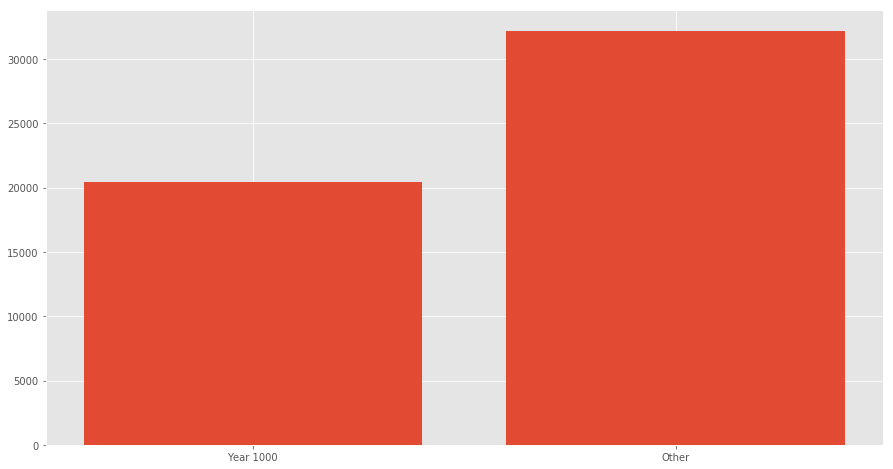

In [9]:
plt.figure(figsize=(15,8));
plt.bar(x=['Year 1000', 'Other'],
        height=[df['SalePrice'][df['YearMade'] == 1000].mean(), df['SalePrice'][df['YearMade'] != 1000].mean()]
       );

In [33]:
st.levene(df['SalePrice'][df['YearMade'] == 1000], df['SalePrice'][df['YearMade'] != 1000])

LeveneResult(statistic=5686.139112272927, pvalue=0.0)

In [34]:
st.ttest_ind(df['SalePrice'][df['YearMade'] == 1000], df['SalePrice'][df['YearMade'] != 1000], equal_var=False)

Ttest_indResult(statistic=-134.61932115652797, pvalue=0.0)

Whether or not the `YearMade` is 1000 may be a good indicator.

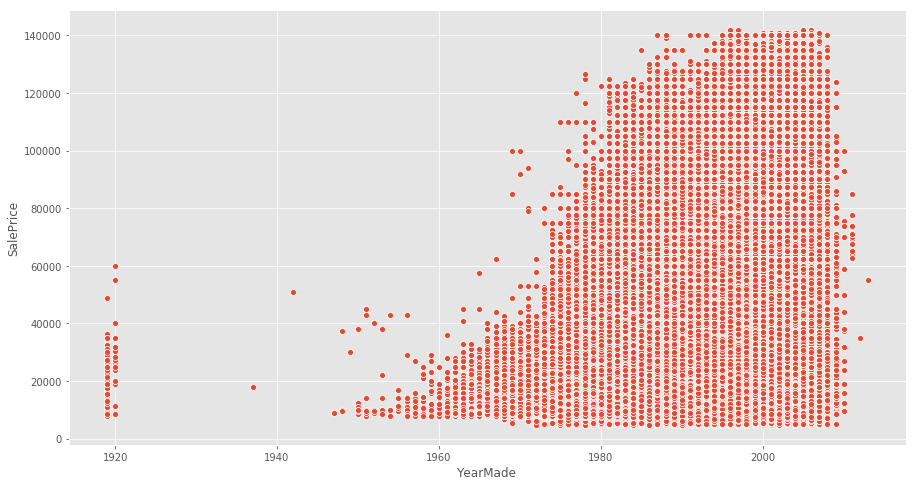

In [10]:
plt.figure(figsize=(15,8));
sns.scatterplot(y='SalePrice', x='YearMade', data=df[df['YearMade'] != 1000]);

`YearMade` looks like it may be indicative of `SalePrice`.

#### `MachineHoursCurrentMeter`

In [11]:
print('Missing Values:', df['MachineHoursCurrentMeter'].isna().sum(),
      '\n\nUnique Values:', df['MachineHoursCurrentMeter'].unique())
display(df.groupby('MachineHoursCurrentMeter')['MachineHoursCurrentMeter'].count())

Missing Values: 258360 

Unique Values: [   68.  4640.  2838. ...  8298. 35740. 12201.]


MachineHoursCurrentMeter
0.0          73126
2.0             18
3.0             21
4.0             35
5.0             44
6.0             20
7.0             12
8.0             18
9.0             13
10.0            33
11.0            12
12.0            12
13.0            20
14.0             9
15.0            17
16.0             8
17.0             7
18.0             8
19.0             6
20.0            10
21.0             5
22.0             7
23.0            10
24.0            41
25.0             9
26.0             8
27.0             9
28.0             8
29.0             7
30.0             8
             ...  
861300.0         1
886200.0         1
892700.0         1
906100.0         1
922100.0         1
932000.0         1
934400.0         1
945300.0         1
968400.0         1
974400.0         1
991000.0         1
1064900.0        1
1098000.0        1
1112100.0        1
1148500.0        1
1189500.0        1
1194900.0        1
1203000.0        1
1209500.0        1
1228200.0        1
128270

In [12]:
missing_machine_df = df[df['MachineHoursCurrentMeter'].isna()]
has_machine_df = df[df['MachineHoursCurrentMeter'].isna()==False]

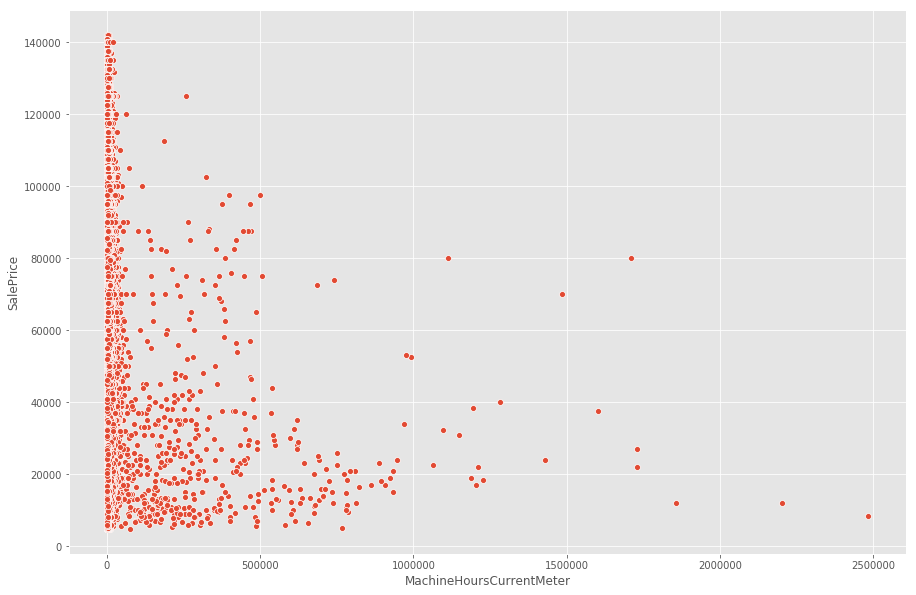

In [13]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='MachineHoursCurrentMeter', y='SalePrice', data=has_machine_df);

In [14]:
st.levene(missing_machine_df['SalePrice'], has_machine_df['SalePrice'])

LeveneResult(statistic=1621.940012027389, pvalue=0.0)

In [15]:
st.ttest_ind(has_machine_df['SalePrice'], missing_machine_df['SalePrice'], equal_var=False)

Ttest_indResult(statistic=49.94917194561435, pvalue=0.0)

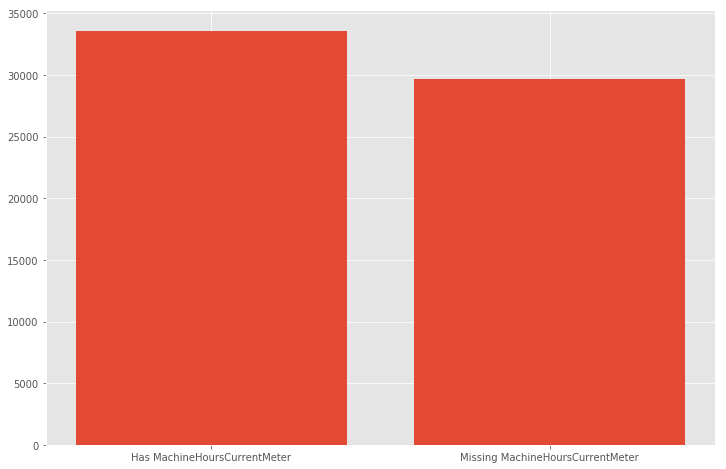

In [16]:
plt.figure(figsize=(12,8));
plt.bar(x = ['Has MachineHoursCurrentMeter', 'Missing MachineHoursCurrentMeter'], 
        height=[has_machine_df['SalePrice'].mean(), missing_machine_df['SalePrice'].mean()]
       );

So it does not look like `MachineHoursCurrentMeter` has a linear relationship with `SalePrice`, but the equipment with the missing feature appears to have a lower mean, which is supported by the t-test.

#### `UsageBand`

In [17]:
print('Missing Values:', df['UsageBand'].isna().sum(),
      '\n\nUnique Values:', df['UsageBand'].unique())
display(df.groupby('UsageBand')['UsageBand'].count())

Missing Values: 331486 

Unique Values: ['Low' 'High' 'Medium' nan]


UsageBand
High      12034
Low       23620
Medium    33985
Name: UsageBand, dtype: int64

Intuition and a little bit of research indicates that this feature has to do with what radio frequency band the equipment operates on. I believe it is suitable to fill the NaN's with 'None or Unspecified' in this case.

#### `fiSecondaryDesc`

In [18]:
print('Missing Values:', df['fiSecondaryDesc'].isna().sum(),
      '\n\nUnique Values:', df['fiSecondaryDesc'].unique())
display(df.groupby('fiSecondaryDesc')['fiSecondaryDesc'].count())

Missing Values: 137191 

Unique Values: ['D' 'F' nan 'G' 'E' 'HAG' 'B' 'NX' 'SUPER K' 'STD' 'BL' 'Z' 'C' 'XT' 'A'
 'H' 'MR' 'PT' 'L' 'M' 'J' 'SE' 'SXT' 'HD' 'LC' 'SUPER M' 'LX' 'SUPER L'
 'LE' 'K' 'S' 'R' 'P' 'SG' 'US' 'UU' 'WX' 'PX' 'N' 'ZTM' 'SUPER E' 'XL'
 'MXT' 'EX' '-2' 'LCM' 'GT' 'TM' 'HZ' 'AX' 'DXT' '3' 'SR' '7' 'ZTS'
 'B     ' 'T' 'UR' '-3' 'V' 'ZT' '1' 'SUPER M PLUS' 'BZD' 'DZ' 'WD' 'LGP'
 'SRLC' 'CH' 'CS' 'M      ' 'ZHS G' 'Q' 'MRX' 'FR' 'UNA' 'R-2' 'PS' 'AG'
 'URG' 'NE' 'U' '2' 'SB' 'TX' 'TTL' 'JX' 'LT' 'MSR SPIN ACE' 'HF' 'HDSL'
 'LCD' 'X' 'LS' 'EST' 'LR' 'TC' 'BLGP' 'USR' 'RC' 'SJ' 'ZF' 'SUPER LE'
 'MT' 'SUPER R' 'C      ' 'BEC' 'DC' 'CE' 'AB' 'MU' 'USRK' 'W' '-7' 'SL'
 'SU' '0.7' 'THF' 'ZX' 'NL' 'CX' 'SRDZ' 'H90' 'AW' 'SP' 'EL' 'PL' '#NAME?'
 'ESS' 'CM' 'CL' 'EW' 'ZHS' 'CR' 'CKB' 'CK' 'DX' 'SX' 'HL' 'HDS' 'DT'
 'LCH' '5' 'H      ' 'SUPER' 'IV' 'XP' 'LD' 'LC7A' 'SF' 'PG' 'SPIN ACE'
 'HX' 'EG' 'HLGP' 'WT' 'XLT' 'MSR' 'BLGPPS' 'AA' 'BZ' 'TP' 'CLR' 'MC'
 'HLS' 'DL' 'USBL' 'LC

fiSecondaryDesc
 MSR SPIN ACE        1
#NAME?              10
-2                  21
-3                   5
-5                   7
-5L                  7
-6                   1
-7                   2
0.7                  8
1                    7
2                    3
3                  125
5                    1
7                  112
A                 5504
AA                   6
AB                   4
AG                  26
AW                   7
AX                  94
B                39203
B                   48
BEC                  7
BL                 562
BLGP                 4
BLGPPS               1
BZ                   6
BZD                 16
C                43235
C                   10
                 ...  
TP                   4
TTL                  1
TX                  27
U                  168
UNA                  3
UR                 820
URG                456
US                 838
USBL                 1
USR                 69
USRK                 3
UU                

#### `fiModelDescriptor`

In [19]:
print('Missing Values:', df['fiModelDescriptor'].isna().sum(),
      '\n\nUnique Values:', df['fiModelDescriptor'].unique())
display(df.groupby('fiModelDescriptor')['fiModelDescriptor'].count())

Missing Values: 329206 

Unique Values: [nan 'LC' '6' 'L' 'LT' 'CR' 'SB' 'XL' 'LGP' 'VHP' '7' 'Z' '2.00E+00' 'MC'
 'H' 'E' '3' 'LK' '5' 'K' '8' 'HT' 'LX' 'XLT' 'XW' 'HSD' '2' 'XR' 'TC'
 'LCR' 'TLB' 'WT' 'TURBO' 'U' '4WD' 'XT' 'LRC' 'ZTS' 'RTS' 'TP' 'LE' 'LRR'
 'SA' '3C' 'SR' 'XP' '1' 'BE' '3NO' 'CRSB' 'N' 'SSR' 'DHP' 'LM' ' SUPER'
 'KA' 'H5' 'II' 'MH' 'P' 'LU' 'DT' 'XTV' 'LR' 'ZX' 'LL' 'V' 'DELUXE'
 'USLC' 'SU' 'SRDZ' 'C' 'PRO' 'PLUS' 'SITEMASTER' 'DINGO' '3.00E+00'
 ' XLT' 'LN' 'AE0' 'SERIES3' '7.00E+00' 'ESL' 'A' 'G' 'B' 'DLL' 'CK'
 'NSUC' 'LS' 'SLGP' 'RR' 'WLT' 'LCRTS' 'X' 'LCH' 'T' 'NLC' 'SM' 'SE' 'TM'
 'SRLC' 'CUSTOM' 'HD' 'DW' 'LC8' ' LGP' 'TK' 'HF' 'SUPER K' 'IV' ' XT'
 'IT' 'XLVP' 'LGPVP' 'K5' '3L' '7A' 'XD' 'DA' 'Y' 'S' 'M' '6K' 'LITRONIC'
 'KBNA' ' 14FT' '2N' 'III' 'ME' 'High Lift' 'HighLift' 'VHP/AWD' 'K3'
 '4x4x4' ' ZX' '(BLADE RUNNER)' 'AVANCE' 'GALEO' 'LongReach']


fiModelDescriptor
 14FT                5
 LGP                 8
 SUPER               7
 XLT                 3
 XT                  2
 ZX                  2
(BLADE RUNNER)       4
1                   59
2                  528
2.00E+00            38
2N                   4
3                 1887
3.00E+00            32
3C                  49
3L                   1
3NO                 42
4WD                 87
4x4x4                1
5                 2246
6                 2885
6K                   2
7                  918
7.00E+00             6
7A                   4
8                  280
A                  300
AE0                  1
AVANCE              11
B                    3
BE                  11
                  ... 
SU                  34
SUPER K              2
T                    1
TC                 186
TK                   1
TLB                 47
TM                  10
TP                  16
TURBO                2
U                  275
USLC                 1
V               

The `fiModel` features appear to collectively describe the model of the equipment. I believe it would be best to simply combine these features into one long string.

In [20]:
df['fiModel'] = df['fiModelDesc'] + '-' +\
                df['fiBaseModel'] + '-' + \
                df['fiSecondaryDesc'].fillna('_') + '-' + \
                df['fiModelSeries'].fillna('').astype(str) + '-' + \
                df['fiModelDescriptor'].fillna('')

In [21]:
df['fiModel'].size

401125

Now there are 5018 unique model types.

#### `ProductSize`

In [22]:
print('Missing Values:', df['ProductSize'].isna().sum(),
      '\n\nUnique Values:', df['ProductSize'].unique())
display(df.groupby('ProductSize')['ProductSize'].count())

Missing Values: 210775 

Unique Values: [nan 'Medium' 'Small' 'Large / Medium' 'Mini' 'Large' 'Compact']


ProductSize
Compact            6089
Large             20975
Large / Medium    49678
Medium            62274
Mini              24840
Small             26494
Name: ProductSize, dtype: int64

In [23]:
(df['fiModel']+df['ProductSize'].fillna('-')).unique().size

5086

Some of the models we have match to multiple `ProductSize` values. So, we can use our engineered `fiModel` feature to see if any of these missing values can be filled.

In [24]:
grouped = df.fillna('-').groupby('fiModel')
grouped['ProductSize'].unique()[(grouped['ProductSize'].nunique() != 1).values].head()

fiModel
120-120-_--      [Small, -, Large / Medium]
125-125-_--     [Large / Medium, Medium, -]
125B-125-B--       [Medium, Large / Medium]
125C-125-C--       [Medium, Large / Medium]
160-160-_--         [Large / Medium, Small]
Name: ProductSize, dtype: object

Using our engineered `fiModel` may be unreliable, so we try the same with `ModelID`.

In [25]:
grouped = df.fillna('-').groupby('ModelID')
grouped['ProductSize'].unique()[(grouped['ProductSize'].nunique() != 1).values].head()

Series([], Name: ProductSize, dtype: object)

There appears to be a discrepancy between `ModelID` and our engineered `fiModel` feature.

In [26]:
grouped = df.fillna('-').groupby('fiModel')
grouped['YearMade'].unique()[(grouped['YearMade'].nunique() != 1).values].head()

fiModel
100C-100-C--      [1973, 1974, 1975, 1977, 1978, 1979, 1000]
1066-1066-_--     [1973, 1975, 1970, 1971, 1000, 1972, 1977]
1080-1080-_--     [1984, 1983, 1985, 1986, 1000, 1987, 1988]
1080B-1080-B--                [1988, 1986, 1985, 1987, 1000]
1088-1088-_--           [1989, 1990, 1000, 1991, 1992, 1988]
Name: YearMade, dtype: object

So now we see that some `YearMade` values are 1000, which is problematic, but I want to see if how `ModelID` and `YearMade` line up.

In [27]:
grouped = df.fillna('-').groupby('ModelID')
year_ = grouped['YearMade'].unique()[(grouped['YearMade'].nunique() != 1).values]

I believe the best course of action is to use the mode by `ModelID` to fill the missing gaps in the above columns and `YearMade`.

#### `YearMade`

In [28]:
year_1000_df = df[df['YearMade'] != 1000]
grouped = year_1000_df.groupby('ModelID')
year_grouped = grouped['YearMade'].value_counts()
year_dict = {}

for model in year_grouped.index.levels[0]:
    if year_grouped[model].idxmax() != 1000:
        year_dict[model] = year_grouped[model].idxmax()

In [29]:
with open('../data/year_dict.pkl', 'wb') as f:
    pickle.dump(year_dict, f)

In [30]:
len(year_dict.keys())

4774

#### `Drive_System`

#### `Enclosure`

#### `Forks`

#### `Pad_Type`

#### `Ride_Control`

#### `Stick`

#### `Transmission`

#### `Turbocharged`

#### `Blade_Extension`

#### `Blade_Width`

#### `Enclosure_Type`

#### `Engine_Horsepower`

#### `Hydraulics`

#### `Pushblock`

#### `Ripper`

#### `Scarifier`

#### `Tip_Control`

#### `Tire_Size`

#### `Coupler`

#### `Track_Type`

#### `Undercarriage_Pad_Width`

#### `Stick_Length`

#### `Thumb`

#### `Pattern_Changer`

#### `Grouser_Type`

#### `Backhoe_Mounting`

#### `Blade_Type`

#### `Travel_Controls`

#### `Differential_Type`

#### `Steering_Controls`